In [187]:
import pybaseball as pyb
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import statsmodels as sm
import seaborn as sns
import scipy as sp
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

# Hypothesis Testing

In [9]:
batting = pyb.lahman.batting()
pitching = pyb.lahman.pitching()
pitching_id = np.array(pitching['playerID'])

batting = batting[batting['AB']>0]
batting = batting[~batting['playerID'].isin(pitching_id)]

career = batting.groupby('playerID').agg({'H': 'sum', 'AB': 'sum'}).reset_index()
career['average'] = career['H']/career['AB']

master = pyb.lahman.master()
master['name'] = master['nameFirst']+' '+master['nameLast']
master_name = master[['playerID', 'name']]

career = pd.merge(master_name, career, on='playerID')

ab_500 = career[career['AB']>=500]
mu = ab_500['average'].mean()
var = ab_500['average'].var()
def estBetaParams(mu, var):
    alpha = ((1 - mu) / var - 1 / mu) * (mu ** 2)
    beta = alpha * (1 / mu - 1)
    
    return {"alpha": alpha, "beta": beta}
estBetaParams(mu, var)
alpha0 = estBetaParams(mu, var)['alpha']
beta0 = estBetaParams(mu, var)['beta']

career['estimate'] = (career['H']+alpha0) / (career['AB']+alpha0+beta0)
career['alpha1'] = alpha0 + career['H']
career['beta1'] = beta0 + career['AB'] - career['H']

# Hall of Fame

타자의 타율이 0.3 이상이어야만 명예의 전당에 들어갈 수 있다고 가정한다. 통계적 추론으로 선수들의 타율에 대한 interval을 추정할 수 있었지만, true 타율이 정확히 0.3 이상이라고 할 수 있을까?  
   
false discover rate control이라는 접근 방식을 통해 

In [28]:
hank = career[career['name']=='Hank Aaron']
hank

,playerID,name,H,AB,average,estimate,alpha1,beta1
0,aaronha01,Hank Aaron,3771,12364,0.304998,0.303863,3850.727541,8821.850676


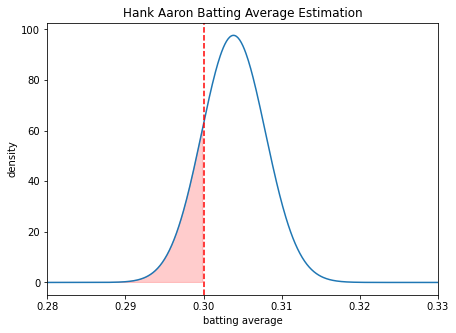

In [40]:
fig, ax = plt.subplots(figsize=(7,5))
x = np.linspace(0, 1, 10000)
ax.plot(x, sp.stats.beta.pdf(x, hank['alpha1'], hank['beta1']))
plt.axvline(x=0.3, color='red', linestyle='--')
x_range=np.arange(0, 0.3, 0.0001)
plt.fill_between(x_range, sp.stats.beta.pdf(x_range, hank['alpha1'], hank['beta1']),color='red', alpha=0.2)
plt.xlim(0.28, 0.33)
plt.title('Hank Aaron Batting Average Estimation')
plt.xlabel('batting average')
plt.ylabel('density')
plt.show()

In [35]:
sp.stats.beta.cdf(0.3, hank['alpha1'], hank['beta1'])

array([0.17226383])

# PEP distribution

In [41]:
career['PEP'] = sp.stats.beta.cdf(0.3, career['alpha1'], career['beta1'])

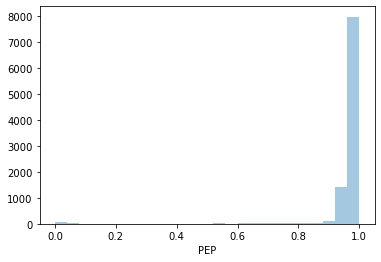

In [55]:
sns.distplot(career['PEP'], kde=False, bins=25)
plt.show()

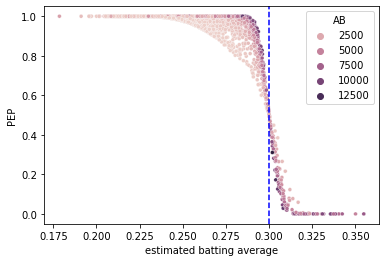

In [54]:
sns.scatterplot(data=career, x='estimate', y='PEP', s=15, hue='AB')
plt.axvline(0.3, color='blue', linestyle='--')
plt.xlabel('estimated batting average')
plt.show()

# False Discovery Rate

In [84]:
arange = career.sort_values(by='PEP').reset_index().drop('index', axis=1)
arange.index = arange.index + 1

top_10 = arange.head(10)
top_10[['name', 'H', 'AB', 'average', 'estimate', 'PEP']]

,name,H,AB,average,estimate,PEP
1,Rogers Hornsby,2930,8173,0.358497,0.354855,1.003669e-27
2,Ed Delahanty,2597,7510,0.345806,0.342355,3.549977e-16
3,Shoeless Joe Jackson,1772,4981,0.355752,0.350071,2.456873e-15
4,Willie Keeler,2932,8591,0.341287,0.338412,2.732979e-15
5,Nap Lajoie,3243,9590,0.338165,0.335677,9.179777e-15
6,Tony Gwynn,3141,9288,0.338178,0.335612,2.534789e-14
7,Harry Heilmann,2660,7787,0.341595,0.338423,4.458292e-14
8,Lou Gehrig,2721,8001,0.340082,0.337048,1.591678e-13
9,Billy Hamilton,2164,6283,0.344421,0.340393,7.821557e-13
10,Eddie Collins,3315,9949,0.333199,0.330948,6.254911e-12


In [85]:
top_91_100 = arange.iloc[90:100]
top_91_100[['name', 'H', 'AB', 'average', 'estimate', 'PEP']]

,name,H,AB,average,estimate,PEP
91,Hank Aaron,3771,12364,0.304998,0.303863,0.172264
92,John Stone,1391,4494,0.309524,0.306237,0.174310
93,Ed Morgan,879,2810,0.312811,0.307425,0.184696
94,George Burns,2018,6573,0.307014,0.304832,0.192152
95,Jose Altuve,1777,5778,0.307546,0.305053,0.196222
96,Home Run Baker,1838,5984,0.307152,0.304760,0.206343
97,Joe Mauer,2123,6930,0.306349,0.304304,0.213419
98,George Kell,2054,6702,0.306476,0.304358,0.214238
99,Joe Vosmik,1682,5472,0.307383,0.304767,0.215962
100,Hack Miller,387,1200,0.322500,0.309382,0.216028


In [102]:
top_100 = arange.head(100)
top_100['PEP'].sum()

5.53388098053954

In [103]:
top_100['PEP'].mean()

0.0553388098053954

In [112]:
top_100['cum_sum'] = top_100['PEP'].cumsum()
top_100['q_value'] = top_100['cum_sum']/top_100.index.to_series()
top_100_ = top_100[['name', 'H', 'AB', 'average', 'estimate', 'PEP', 'q_value']]
top_100_

,name,H,AB,average,estimate,PEP,q_value
1,Rogers Hornsby,2930,8173,0.358497,0.354855,1.003669e-27,1.003669e-27
2,Ed Delahanty,2597,7510,0.345806,0.342355,3.549977e-16,1.774989e-16
3,Shoeless Joe Jackson,1772,4981,0.355752,0.350071,2.456873e-15,9.372902e-16
4,Willie Keeler,2932,8591,0.341287,0.338412,2.732979e-15,1.386212e-15
5,Nap Lajoie,3243,9590,0.338165,0.335677,9.179777e-15,2.944925e-15
...,...,...,...,...,...,...,...
96,Home Run Baker,1838,5984,0.307152,0.304760,2.063431e-01,4.868993e-02
97,Joe Mauer,2123,6930,0.306349,0.304304,2.134191e-01,5.038817e-02
98,George Kell,2054,6702,0.306476,0.304358,2.142379e-01,5.206011e-02
99,Joe Vosmik,1682,5472,0.307383,0.304767,2.159623e-01,5.371568e-02


In [113]:
hall_of_fame = top_100_[top_100_['q_value']<0.05]
hall_of_fame

,name,H,AB,average,estimate,PEP,q_value
1,Rogers Hornsby,2930,8173,0.358497,0.354855,1.003669e-27,1.003669e-27
2,Ed Delahanty,2597,7510,0.345806,0.342355,3.549977e-16,1.774989e-16
3,Shoeless Joe Jackson,1772,4981,0.355752,0.350071,2.456873e-15,9.372902e-16
4,Willie Keeler,2932,8591,0.341287,0.338412,2.732979e-15,1.386212e-15
5,Nap Lajoie,3243,9590,0.338165,0.335677,9.179777e-15,2.944925e-15
...,...,...,...,...,...,...,...
92,John Stone,1391,4494,0.309524,0.306237,1.743097e-01,4.233500e-02
93,Ed Morgan,879,2810,0.312811,0.307425,1.846963e-01,4.386576e-02
94,George Burns,2018,6573,0.307014,0.304832,1.921518e-01,4.544327e-02
95,Jose Altuve,1777,5778,0.307546,0.305053,1.962225e-01,4.703042e-02


In [123]:
hall_of_fame_001 = top_100_[top_100_['q_value']<0.01]
hall_of_fame_001

,name,H,AB,average,estimate,PEP,q_value
1,Rogers Hornsby,2930,8173,0.358497,0.354855,1.003669e-27,1.003669e-27
2,Ed Delahanty,2597,7510,0.345806,0.342355,3.549977e-16,1.774989e-16
3,Shoeless Joe Jackson,1772,4981,0.355752,0.350071,2.456873e-15,9.372902e-16
4,Willie Keeler,2932,8591,0.341287,0.338412,2.732979e-15,1.386212e-15
5,Nap Lajoie,3243,9590,0.338165,0.335677,9.179777e-15,2.944925e-15
...,...,...,...,...,...,...,...
59,Cecil Travis,1544,4914,0.314204,0.310905,4.362380e-02,7.337514e-03
60,Elmer Flick,1752,5597,0.313025,0.310169,4.491708e-02,7.963840e-03
61,Sam Crawford,2961,9570,0.309404,0.307810,4.580333e-02,8.584160e-03
62,Bibb Falk,1463,4652,0.314488,0.310998,4.642760e-02,9.194538e-03


## q-value

(0.0, 300.0)

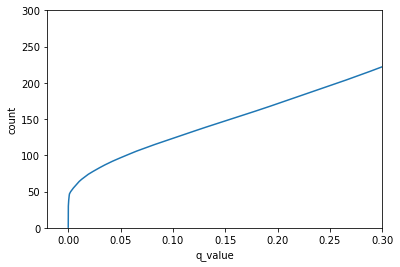

In [122]:
arange
arange['count'] = arange.index.to_series()
arange['cum_sum'] = arange['PEP'].cumsum()
arange['q_value'] = arange['cum_sum']/arange.index.to_series()
arange_ = arange[['name', 'H', 'AB', 'average', 'estimate', 'PEP', 'q_value', 'count']]

sns.lineplot(data=arange_, x='q_value', y='count')
plt.xlim(-0.02, 0.3)
plt.ylim(0,300)

# A/B Testing

In [130]:
aaron = career[career['name']=='Hank Aaron']
piazza = career[career['name']=='Mike Piazza']
matsui = career[career['name']=='Hideki Matsui']

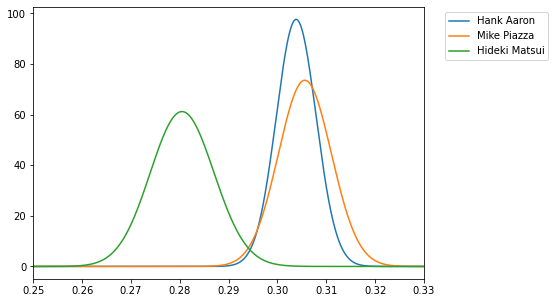

In [135]:
fig, ax = plt.subplots(figsize=(7,5))
x = np.linspace(0, 1, 10000)
ax.plot(x, sp.stats.beta.pdf(x, aaron['alpha1'], aaron['beta1']), label='Hank Aaron')
ax.plot(x, sp.stats.beta.pdf(x, piazza['alpha1'], piazza['beta1']), label='Mike Piazza')
ax.plot(x, sp.stats.beta.pdf(x, matsui['alpha1'], matsui['beta1']), label='Hideki Matsui')
plt.xlim(0.25, 0.33)
plt.legend()
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

## simulation

In [174]:
aaron_sim = np.random.beta(aaron['alpha1'], aaron['beta1'], size=1000000)
piazza_sim = np.random.beta(piazza['alpha1'], piazza['beta1'], size=1000000)
sim = np.mean(aaron_sim<piazza_sim)
sim

0.604421

## approximation

In [173]:
def approx_norm(alpha1, beta1, alpha2, beta2):
    u1 = alpha1/(alpha1+beta1)
    u2 = alpha2/(alpha2+beta2)
    var1 = (alpha1*beta1)/(((alpha1+beta1)**2)*(alpha1+beta1+1))
    var2 = (alpha2*beta2)/(((alpha2+beta2)**2)*(alpha2+beta2+1))
    return sp.stats.norm.cdf(0, loc=u1-u2, scale=np.sqrt(var1+var2))[0]

approx_norm(aaron['alpha1'].values, aaron['beta1'].values, piazza['alpha1'].values, piazza['beta1'].values)

0.6043167725961089

# Confidence Interval / Credible Interval

In [191]:
hits = np.array([aaron['H'].values, piazza['H'].values])
ABs = np.array([aaron['AB'].values, piazza['AB'].values])

stat, p_value = sm.stats.proportion.proportions_ztest(count=hits, nobs=ABs,  alternative='two-sided')

p_value

array([0.68880128])

In [220]:
career[(career['name']=='Hank Aaron')|(career['name']=='Mike Piazza')][['name', 'H', 'AB']]

,name,H,AB
0,Hank Aaron,3771,12364
7012,Mike Piazza,2127,6911


In [199]:
low, upp = sm.stats.proportion.confint_proportions_2indep(aaron['H'].values, aaron['AB'].values, piazza['H'].values, piazza['AB'].values,
                                              compare='diff', alpha=0.05)
(low, upp)

(array([-0.01639412]), array([0.01075166]))

In [247]:
sample20 = career.sample(n=20).sort_values(by='AB', ascending=False)
sample20

,playerID,name,H,AB,average,estimate,alpha1,beta1,PEP
1607,clarkja01,Jack Clark,1826,6847,0.266686,0.266328,1905.727541,5249.850676,1.000000
8501,stanlmi02,Mike Stanley,1138,4222,0.269541,0.268780,1217.727541,3312.850676,0.999998
8294,smithea02,Earl Smith,686,2264,0.303004,0.297650,765.727541,1806.850676,0.604920
6666,ontivst01,Steve Ontiveros,600,2193,0.273598,0.271719,679.727541,1821.850676,0.999103
2275,diazal02,Aledmys Diaz,453,1674,0.270609,0.268704,532.727541,1449.850676,0.998966
1084,brownwi01,William Brown,415,1589,0.261171,0.260715,494.727541,1402.850676,0.999925
1802,cooneji01,Jimmy Cooney,315,1302,0.241935,0.245084,394.727541,1215.850676,1.000000
7634,rohege01,George Rohe,197,868,0.226959,0.235197,276.727541,899.850676,1.000000
3337,goodwpe01,Pep Goodwin,142,603,0.235489,0.243235,221.727541,689.850676,0.999935
2970,fritzha01,Harry Fritz,96,423,0.226950,0.240203,175.727541,555.850676,0.999852


In [248]:
low_list=[]
upp_list=[]
ci_low_list=[]
ci_upp_list=[]
alpha1=piazza['alpha1'].values
beta1=piazza['beta1'].values
h=piazza['H'].values
ab=piazza['AB'].values
for i in range(len(sample20)):
    alpha2=sample20.iloc[i]['alpha1']
    beta2=sample20.iloc[i]['beta1']
    
    u1 = alpha1/(alpha1+beta1)
    u2 = alpha2/(alpha2+beta2)
    var1 = (alpha1*beta1)/(((alpha1+beta1)**2)*(alpha1+beta1+1))
    var2 = (alpha2*beta2)/(((alpha2+beta2)**2)*(alpha2+beta2+1))
    
    mu_diff = u2-u1
    sd_diff = np.sqrt(var1+var2)
    
    low, upp = sp.stats.norm.interval(loc=mu_diff, scale=sd_diff, alpha=0.95)
    low_list.append(low)
    upp_list.append(upp)
    
    ci_low, ci_upp = sm.stats.proportion.confint_proportions_2indep(sample20.iloc[i]['H'], sample20.iloc[i]['AB'], h, ab,
                                              compare='diff', alpha=0.05)
    ci_low_list.append(ci_low)
    ci_upp_list.append(ci_upp)
    
sample20['cr_low'] = low_list
sample20['cr_upp'] = upp_list
sample20['ci_low'] = ci_low_list
sample20['ci_upp'] = ci_upp_list

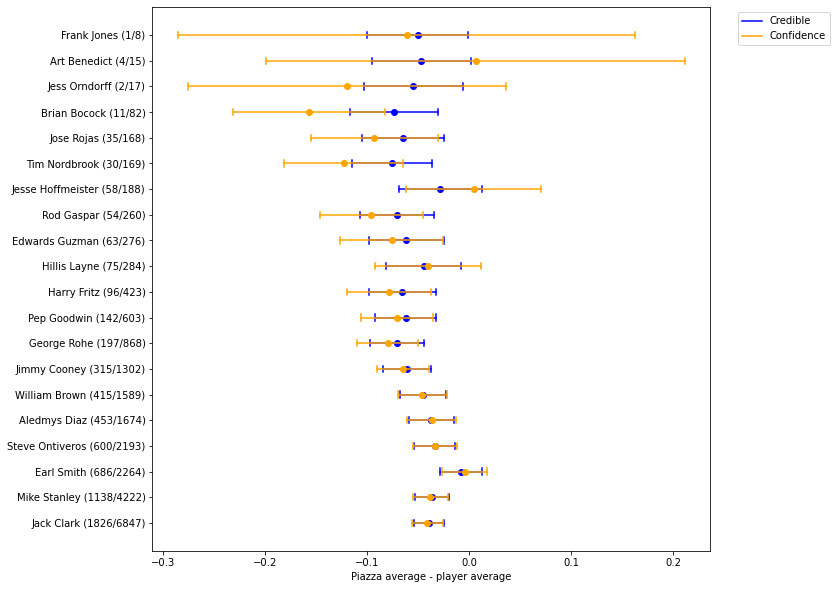

In [249]:
vertical_line_width=0.25

plt.figure(figsize=(10,10))
label_added =False
for i in range(len(sample20)):
    y=i
    top = y - vertical_line_width / 2
    bottom = y + vertical_line_width / 2
    left_cr = sample20.iloc[i]['cr_low']
    left_ci = sample20.iloc[i]['ci_low']
    right_cr = sample20.iloc[i]['cr_upp']
    right_ci = sample20.iloc[i]['ci_upp']
    if not label_added:
        plt.plot([left_cr, right_cr], [y, y], color='blue', label='Credible')
        plt.plot([left_cr, left_cr], [bottom, top], color='blue')
        plt.plot([right_cr, right_cr], [bottom, top], color='blue')
        plt.plot((right_cr+left_cr)/2, y,'o', color='blue')
        plt.plot([left_ci, right_ci], [y, y], color='orange', label='Confidence')
        plt.plot([left_ci, left_ci], [bottom, top], color='orange')
        plt.plot([right_ci, right_ci], [bottom, top], color='orange')
        plt.plot((right_ci+left_ci)/2, y,'o', color='orange')
        label_added = True
    else:
        plt.plot([left_cr, right_cr], [y, y], color='blue')
        plt.plot([left_cr, left_cr], [bottom, top], color='blue')
        plt.plot([right_cr, right_cr], [bottom, top], color='blue')
        plt.plot((right_cr+left_cr)/2, y,'o', color='blue')
        
        plt.plot([left_ci, right_ci], [y, y], color='orange')
        plt.plot([left_ci, left_ci], [bottom, top], color='orange')
        plt.plot([right_ci, right_ci], [bottom, top], color='orange')
        plt.plot((right_ci+left_ci)/2, y,'o', color='orange')
    
plt.yticks(range(len(sample20)),list(sample20['name']+' ('+sample20['H'].astype('str')+'/'+sample20['AB'].astype('str')+')'))
plt.legend()
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.xlabel('Piazza average - player average')
plt.show()